In [1]:
!nvidia-smi

import os
from google.colab import drive

drive.mount('/content/gdrive')

work_root = "/content/gdrive/My Drive/cigarette_butt_segmentation"
%cd "$work_root"
data_root = '/content/data'
if not os.path.exists(data_root):
    !unzip data/cig_butts.zip -d $data_root
    !mv $data_root/cig_butts/* $data_root
    !rm -r $data_root/cig_butts 
out_dir = work_root + '/results'
weights_file_name_templ = out_dir + '/CigHeadWeights_Epoch%d.h5'

if 0:       # Warning: one-time operation, then the sources are supposed to be edited
    %cd /content
    !git clone https://github.com/pytorch/vision.git
    %cd vision
    !git checkout v0.3.0

    target_dir = work_root + "/lib/detection"
    %mkdir "$target_dir"
    # # !cp references/detection/utils.py ../
    # # !cp references/detection/transforms.py ../
    # !cp references/detection/coco_eval.py "$work_root/lib/torchvision/"
    # !cp references/detection/engine.py "$work_root/lib/torchvision/"
    # # !cp references/detection/coco_utils.py ../
    !cp references/detection/*.py "$target_dir/"

    %cd $work_root

Mon Oct  5 17:31:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import ImageFile
from glob import glob

from lib import *
from lib.net import *
from lib.dataset import *

# from lib.torchvision.transforms1 import get_transform
# from lib.torchvision import train
# from lib.torchvision import engine
# from lib.torchvision.utils import *

# %ls -l lib/detection/
import lib.detection.transforms as T
# from lib.detection.transforms import get_transform
from lib.detection import train
from lib.detection.det_utils import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# import torchvision.models.segmentation as segmentation

# # model = segmentation.deeplabv3_resnet50(True, True, 2)
#     # Fails because it is pretrained on 21 classes

# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# # load a model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# # replace the classifier with a new one, that has
# # num_classes which is user-defined
# num_classes = 2  # 1 class (person) + background
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model = get_instance_segmentation_model(num_classes, True)
model.to(device)
# criterion = train.get_criterion()
epochNum = 0

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size=3,
#                                                gamma=0.1)

In [13]:
if 0:
    save_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
    save_model_state(model, (weights_file_name_templ % epochNum) + '_full')
elif 0:
    epochNum = 34
    load_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
    load_model_state(model, (weights_file_name_templ % epochNum) + '_full')  

In [14]:
def get_transform(train):
    transforms = []
    # if train:
    #     transforms.append(T.RandomMaskedObjectCopy(10))
    # Converts a PIL image into PyTorch Tensor. My RandomMaskedObjectCopy works on PIL images so it has to be before
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))        
    return T.Compose(transforms)
    
dataset = CigDataset(data_root + '/train', get_transform(train=True))
dataset_test = CigDataset(data_root + '/val', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, range(100))
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# dataset[0]

2000 images found
200 images found


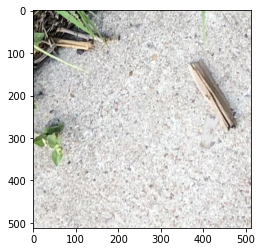

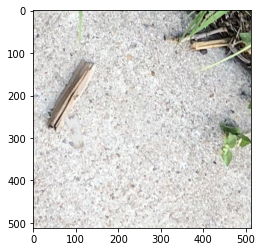

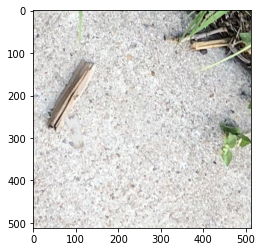

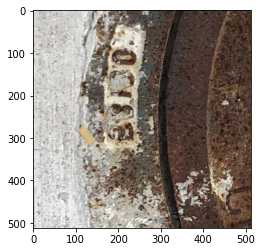

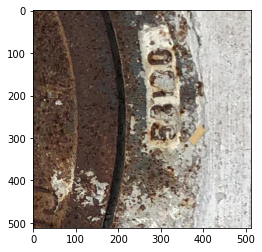

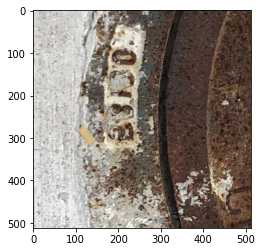

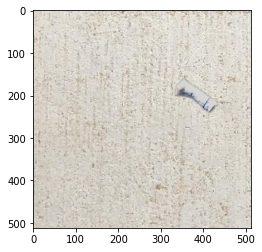

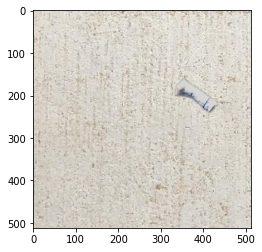

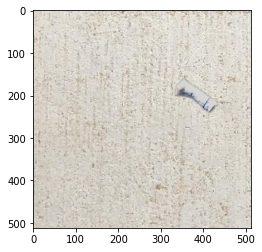

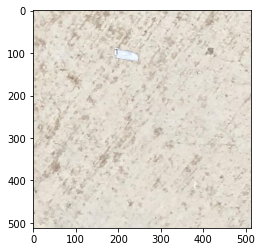

In [15]:
for i in range(10):
    img, target = dataset[i // 3 + 1]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [16]:
# train.evaluate(model, data_loader, device=device, printFunc=printProgress)   

In [17]:
# def engine_get_dice(target, pred, threshold=0.5): 
#     # print(src_targets)
#     target_mask_count = target['masks'].shape[0]
#     if target_mask_count == 0:
#         return 0
#     target_mask_sum = target['masks'][0].numpy()
#     for i in range(1, target_mask_count):
#         target_mask_sum += target['masks'][i].numpy()
#     target_mask = (target_mask_sum > 0)

#     # print(target_mask_sum.shape, np.where(target_mask))
#     print('engine_get_dice', 'target_mask.sum()', target_mask.sum(), pred['masks'].shape)
#     pred_mask_count = output['masks'].shape[0]
#     if pred_mask_count == 0:
#         return 0
        
#     intersection_sum = 0
#     im_sum = target_mask.sum()
#     preds = pred['masks'].numpy() > threshold
#     for mask_ind in range(pred_mask_count):
#         pred_mask = preds[mask_ind, 0]
#         print('pred_mask ', pred_mask.shape)
#         intersection_sum += (target_mask & pred_mask).sum()
#         im_sum += pred_mask.sum()
#     return 2.0 * intersection_sum / (im_sum + 1e-1)
        
# dices = engine.d
# np.mean(dices)
# print(type(np.mean(dices)))
# printProgress("Dices avg %.5f, all: %s" % (np.mean(dices), str(dices)))
# # engine_get_dice(engine.s, engine.p)
# # (engine.t[2]['masks'].shape)

In [40]:
num_epochs = 100

learnRate = 2e-3
for epoch in range(num_epochs):
    train.evaluate(model, data_loader_test, device=device, printFunc=printProgress)   
    for g in optimizer.param_groups:
        g['lr'] = learnRate
    train.train_one_epoch(model, optimizer, data_loader, device, epochNum, 
                          print_freq=10, printFunc=printProgress)
    # train.train_one_epoch(model, train.criterion, optimizer, data_loader, lr_scheduler, device,
    #                       epochNum, print_freq=10)
    # lr_scheduler.step()
    
    epochNum += 1
    if epochNum % 5 == 0:
        save_model_state(model.roi_heads.mask_predictor, weights_file_name_templ % epochNum)
        save_model_state(model, (weights_file_name_templ % epochNum) + '_full') 
    # train.evaluate(model, data_loader_test, device=device, printFunc=printProgress)    
    
    if epochNum % 15 == 0:
        learnRate /= 5    

creating index...
index created!
Test:  [  0/200]  eta: 0:02:09  model_time: 0.3028 (0.3028)  evaluator_time: 0.0801 (0.0801)  time: 0.6461  data: 0.1784  max mem: 670
Test:  [100/200]  eta: 0:00:31  model_time: 0.1563 (0.1602)  evaluator_time: 0.0832 (0.0830)  time: 0.3113  data: 0.0039  max mem: 670
Test:  [199/200]  eta: 0:00:00  model_time: 0.1565 (0.1586)  evaluator_time: 0.0826 (0.0829)  time: 0.3100  data: 0.0036  max mem: 670
Test: Total time: 0:01:03 (0.3180 s / it)
Averaged stats: dice 0.01315, model_time: 0.1565 (0.1586)  evaluator_time: 0.0826 (0.0829)
Dices: [0.015877139591158083, 0.019738077356364993, 0.0011587006000413817, 0.013214521238650226, 0.0, 0.007139924796693739, 0.01724875328620418, 0.005630988511591692, 0.006061417843142508, 0.010330626138136106, 0.013420910717549394, 0.00923204362246, 0.017121708217675145, 0.003786386142854694, 0.002769974219355136, 0.004416065042521164, 0.0058243428966821865, 0.020463161871939934, 0.005667399126169287, 0.015156057670042534, 0

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [  0/250]  eta: 0:11:01  lr: 0.000010  loss: 3.8262 (3.8262)  loss_classifier: 0.5801 (0.5801)  loss_box_reg: 0.1124 (0.1124)  loss_mask: 3.1247 (3.1247)  loss_objectness: 0.0069 (0.0069)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 2.6453  data: 1.1532  max mem: 5904
Epoch: [0]  [ 10/250]  eta: 0:04:26  lr: 0.000090  loss: 3.4016 (3.0625)  loss_classifier: 0.5084 (0.4872)  loss_box_reg: 0.1169 (0.1155)  loss_mask: 2.7405 (2.4377)  loss_objectness: 0.0114 (0.0205)  loss_rpn_box_reg: 0.0014 (0.0016)  time: 1.1121  data: 0.1230  max mem: 6185
Epoch: [0]  [ 20/250]  eta: 0:03:59  lr: 0.000171  loss: 1.0819 (1.9312)  loss_classifier: 0.3000 (0.3348)  loss_box_reg: 0.1207 (0.1201)  loss_mask: 0.6445 (1.4556)  loss_objectness: 0.0173 (0.0193)  loss_rpn_box_reg: 0.0011 (0.0015)  time: 0.9603  data: 0.0227  max mem: 6185
Epoch: [0]  [ 30/250]  eta: 0:03:43  lr: 0.000251  loss: 0.5063 (1.4538)  loss_classifier: 0.1052 (0.2584)  loss_box_reg: 0.1266 (0.1251)  loss_mask: 0.2579 (1.0525) 

KeyboardInterrupt: ignored

# Анализ получившейся сети

In [ ]:
def show_pred_masks(dataset, img_idxs, plot_col_count,
                    log_thresholds, threshold_to_use_ind):
    """Runs model on the images, calculate dices on them on different thresholds
    and plot masks with dice < 0.95
    """

    model.eval()
    plot_row_count = 1
    dices = []
    with torch.no_grad():
        for img_idx2, img_idx in enumerate(img_idxs):
            img, target = dataset[img_idx]
            images = images_to_device(img, device)
            targets = targets_to_device(target, device)
            pred = model(images)
            masks = pred[0]['masks'].cpu()

            mask_count = masks.shape[0]
            cur_dices = []
            for threshold in log_thresholds:
                if mask_count != 0:
                    dice = get_dice(target['masks'][0].numpy().astype(bool),
                                    masks[0, 0].numpy() > threshold) / mask_count
                        # Некоторая вариация метрики - лишние предсказанные маски кратно понижают оценку
                else:
                    dice = 0
                cur_dices.append(dice)
            print('Image %d 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: %s, masks: %s, %d' % \
                (img_idx, ', '.join([('%.3f' % d) for d in cur_dices]), masks.shape, mask_count))
            dices.append(cur_dices[threshold_to_use_ind])
            if cur_dices[threshold_to_use_ind] > 0.95:
                continue

            plt.figure(figsize=(12, 8))        
            zero_mask = np.zeros(list(masks.shape[2:]))
            mask_sum = np.copy(zero_mask)        
            for mask_ind in range(min(plot_col_count - 1, mask_count)):
                # mask = masks[mask_ind, 0].mul((mask_ind + 1) * 10).byte().numpy()
                mask = masks[mask_ind, 0].numpy()
                where = np.where(mask > 0.5)
                # where = (where[0] , where[1] + 50)
                # mask[where] = 0.3
                target_where = np.where(target['masks'][0].numpy() > 0)
                # print('where', mask[where][:50])
                print('target bbox', target['boxes'])
                print('Mask min %.2f, max %.2f, coords (%.1f, %.1f), area %d, target area %d' % \
                    (mask[where].min(), mask.max(), where[1][0], where[0][0], len(where[0]),
                    len(target_where[0])))
                # mask_sum[where] = mask_sum[where] * 0.7 + 0.3
                mask_rgb = np.stack([mask, target['masks'][0], zero_mask], axis=2)
                mask_rgb = np.array(mask_rgb * 255, dtype=np.uint8)

                
                bbox = expand_bbox(target['boxes'][0].numpy().astype(int), 15, mask.shape[-1])
                ax = plt.subplot(plot_row_count, plot_col_count, mask_ind + 2)
                    # For plots matrix - also img_idx2 * plot_col_count + 
                im = ax.imshow(mask_rgb[bbox[1] : bbox[3], bbox[0] : bbox[2]]) # [100:400, 100:400]) 
                # plt.colorbar(im, ax=ax)
            # print(mask_sum.shape, target['masks'].shape)
            # mask_sum = np.stack([mask_sum, target['masks'][0], zero_mask], axis=2) * 255
            ax = plt.subplot(plot_row_count, plot_col_count, 1)
            # im = ax.imshow(mask_sum)
            im = ax.imshow(np.transpose(img, (1, 2, 0)))

            # # Runs the entire evaluator on one image. But the results are non-visual
            # one_img_dataset = torch.utils.data.Subset(dataset, [img_idx])
            # one_img_data_loader = torch.utils.data.DataLoader(
            #         one_img_dataset, batch_size=1, shuffle=False, num_workers=1,
            #         collate_fn=collate_fn)
            # train.evaluate(model, one_img_data_loader, device=device)
            plt.show()
    return np.array(dices)

img_idxs = range(200)  
plot_col_count = 4
log_thresholds = [0.1, 0.3, 0.5, 0.7, 0.95]
threshold_to_use_ind = 2
dices = show_pred_masks(dataset_test, img_idxs, plot_col_count,
                        log_thresholds, threshold_to_use_ind)

sorted_dice_inds = np.argsort(dices)
print('Threshold %f dices: %s' % (log_thresholds[threshold_to_use_ind], dices[sorted_dice_inds]))
print('Dices mean: %.5f' % np.mean(dices))
# pred
# Image.fromarray(pred[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
# Had no time to fix for multiple objects
img_idxs = range(300)  # sorted_dice_inds[:10]
rowCount = 1 # len(img_idxs)
colCount = 5
log_thresholds = [0.1, 0.3, 0.5, 0.7, 0.95]
threshold_to_use_ind = 2
model.eval()
dices = []
with torch.no_grad():
    for img_idx2, img_idx in enumerate(img_idxs):
        img, target = dataset[img_idx]
        images = images_to_device(img, device)
        targets = targets_to_device(target, device)
        pred = model(images)
        masks = pred[0]['masks'].cpu()

        mask_count = masks.shape[0]
        cur_dices = []
        for threshold in [0.1, 0.3, 0.5, 0.7, 0.95]:
            if mask_count != 0:
                dice = get_dice(target['masks'][0].numpy().astype(bool),
                                masks[0, 0].numpy() > threshold) / mask_count
                    # Некоторая вариация метрики - лишние предсказанные маски кратно понижают оценку
            else:
                dice = 0
            cur_dices.append(dice)
        print('Image %d 0.1, 0.3, 0.5, 0.7, 0.95 thresholds dices: %s, masks: %s, %d' % \
              (img_idx, ', '.join([('%.3f' % d) for d in cur_dices]), masks.shape, mask_count))
        dices.append(cur_dices[threshold_to_use_ind])
        if cur_dices[threshold_to_use_ind] > 0.95:
            continue

        plt.figure(figsize=(12, 8))        
        print('target bboxes', target['boxes'])
        pred_boxes = pred[0]['boxes'].cpu().numpy()
        zero_mask = np.zeros(list(masks.shape[2:]))
        mask_sum = np.copy(zero_mask)        
        for mask_ind in range(min(colCount - 1, mask_count)):
            # mask = masks[mask_ind, 0].mul((mask_ind + 1) * 10).byte().numpy()
            mask = masks[mask_ind, 0].numpy()
            where = np.where(mask > 0.5)
            # where = (where[0] , where[1] + 50)
            # mask[where] = 0.3

            target_mask_ind = find_nearest_bbox(pred_boxes[mask_ind], target['boxes'].numpy())
            print('pred', target['boxes'][target_mask_ind].numpy())
            bbox = expand_bbox(target['boxes'][target_mask_ind].numpy().astype(int), 15, mask.shape[-1])
            target_where = np.where(target['masks'][target_mask_ind].numpy() > 0)
            # print('where', mask[where][:50])
            print('Mask min %.2f, max %.2f, coords (%.1f, %.1f), area %d, target area %d' % \
                  (mask[where].min(), mask.max(), where[1][0], where[0][0], len(where[0]),
                   len(target_where[0])))
            # mask_sum[where] = mask_sum[where] * 0.7 + 0.3
            mask_rgb = np.stack([mask, target['masks'][0], zero_mask], axis=2)
            mask_rgb = np.array(mask_rgb * 255, dtype=np.uint8)
            
            ax = plt.subplot(rowCount, colCount, mask_ind + 2)
                # For plots matrix - also img_idx2 * colCount + 
            im = ax.imshow(mask_rgb)  # [bbox[1] : bbox[3], bbox[0] : bbox[2]]) # [100:400, 100:400]) 
            # plt.colorbar(im, ax=ax)
        # print(mask_sum.shape, target['masks'].shape)
        # mask_sum = np.stack([mask_sum, target['masks'][0], zero_mask], axis=2) * 255
        ax = plt.subplot(rowCount, colCount, 1)
        # im = ax.imshow(mask_sum)
        im = ax.imshow(np.transpose(img, (1, 2, 0)))

        # # Runs the entire evaluator on one image. But the results are non-visual
        # one_img_dataset = torch.utils.data.Subset(dataset, [img_idx])
        # one_img_data_loader = torch.utils.data.DataLoader(
        #         one_img_dataset, batch_size=1, shuffle=False, num_workers=1,
        #         collate_fn=collate_fn)
        # train.evaluate(model, one_img_data_loader, device=device)
        plt.show()

dices = np.array(dices)
sorted_dice_inds = np.argsort(dices)
print('Threshold %f dices: %s' % (log_thresholds[threshold_to_use_ind], dices[sorted_dice_inds]))
print('Dices mean: %.5f' % np.mean(dices))
# pred
# Image.fromarray(pred[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Запись в pred_val_template.csv

# Данные, метрики и доступные функции

Посмотрим на данные:

In [ ]:
def show_images(data_path, img_ids):
    images = os.listdir(f"{data_path}/images")
    annotations = json.load(open(f"{data_path}/coco_annotations.json", "r"))
    for img_id in img_ids:
        img = None
        for ext in ['png', 'jpg', 'jpeg', 'gif']:
            img_path = f"{data_path}/images/{img_id:08}.{ext}"
            if os.path.exists(img_path):
                img = np.array(Image.open(img_path))
        mask = utils.get_mask(img_id, annotations)  # [130:170, 270:350]
        show.show_img_with_mask(img, mask)
    return mask
    
mask = show_images(f"{data_root}/val", [3, 5])      # A couple of strange val. images

Пример подсчета метрики:

In [ ]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask), np.sum((mask > 0).astype(int)) / mask.size

// Можно для последовательности масок вычислить среднее значение метрики


Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [ ]:
rle_mask = encode_rle(mask)
rle_mask

# Сохранение результатов

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [ ]:
pred = pd.read_csv("data/pred_val_template.csv")
pred.head()

In [ ]:
# Preparation of data for storing pngs from dataset
threshold = 0.5
pred_masks_by_id = {}
model.eval()
with torch.no_grad():
    for img_idx2, (img, target) in enumerate(dataset_test):
        images = images_to_device(img, device)
        targets = targets_to_device(target, device)
        pred = model(images)
        masks = pred[0]['masks'].cpu().numpy()

        mask_count = masks.shape[0]
        if mask_count == 0:
            print('No mask for image %d' % img_idx2)
            mask2 = np.zeros(list(img.size())[-2:])
        else:
            mask = masks[0, 0]
            mask2 = (mask > threshold).astype(np.uint8)
            mask2[mask2 > 0] = 255
            img_id = int(targets[0]['image_id'])
        pred_masks_by_id[img_id] = mask2

        if img_idx2 < 3:
            print(img_id, mask2)           
            
            plt.figure(figsize=(8, 5))        
            im = plt.imshow(mask2)
            plt.show()

In [ ]:
# Preparation of data for storing pngs from folder real_test
# Прогоним на папке real_test
paths_to_imgs = sorted(glob(f"{data_root}/real_test/*"))
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
threshold = 0.5
pred_masks_by_id = {}
model.eval()
with torch.no_grad():
    transforms = get_transform(False)
    for img_idx2, paths_to_img in enumerate(paths_to_imgs):
        img = Image.open(paths_to_img).convert("RGB") 
        images = transforms(img, None)
        # print(images[0].max(), images[0].shape, images[0].dtype)
        images = np.expand_dims(images[0], 0)
        images = torch.from_numpy(images).to(device)
        print(images.sum())
        pred = model(images)
        masks = pred[0]['masks'].cpu().numpy()

        # print('Result shapes:', len(pred), masks.shape, masks.sum())
        mask_count = masks.shape[0]
        if mask_count == 0:
            continue
            # raise Exception('No mask for image %d' % img_idx2)
        
        mask = masks[0, 0]
        mask = (mask > threshold).astype(np.uint8)
        for mask_ind in range(1, mask_count):
            mask2 = masks[mask_ind, 0]
            # wh = np.where(masks[mask_ind, 0] > threshold)
            # print(wh[0][:10])
            mask[mask2 > threshold] = 2
        mask[mask > 0] = 255
        img_id = img_ids[img_idx2]
        pred_masks_by_id[img_id] = mask
        if img_idx2 < 2:
            # print(img_id, mask2)           
            
            plt.figure(figsize=(8, 5))        
            # plt.imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
            im = plt.imshow(mask)
            plt.show()

In [ ]:
fieldNames = ['img_id', 'rle_mask']
table = []
for img_id, mask in pred_masks_by_id.items():
    table.append((img_id, encode_rle(mask)))
data_frame = pd.DataFrame(table, columns=fieldNames)
data_frame.to_csv('results/pred_val_template.csv', index=False)

In [ ]:
%ls -l results

In [ ]:
# val_annotations = json.load(open(f"{data_root}/val/coco_annotations.json", "r"))
# paths_to_imgs = sorted(glob(f"{data_root}/val/images/*"))
# paths_to_imgs = paths_to_imgs[:10]
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
# masks1 = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]
masks = [pred_masks_by_id[img_id] for img_id in sorted(img_ids)]

path_to_save = "results/example"
generate_images_for_html(paths_to_imgs, masks, path_to_save=path_to_save)     
generate_html(path_to_save)

mask = masks[0]
mask.shape, mask.dtype, mask.sum(), mask
encode_rle(mask)

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.